<a href="https://colab.research.google.com/github/ii200400/Tensorflow_Tutorial/blob/master/09%20-%20GAN/02_GAN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 개요

GAN 모델을 이용하여 원하는 손글씨 숫자를 생성하는 모델을 만들기

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

## 데이터 정의

In [ ]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./mnist/data/", one_hot=True)

## 모델 구성

### 옵션 설정

In [ ]:
total_epoch = 100
batch_size = 100

n_hidden = 256
n_input = 28 * 28
n_noise = 128
n_class = 10

### 신경망 구성

In [ ]:
X = tf.placeholder(tf.float32, [None, n_input])
# 노이즈와 실제 이미지에, 그에 해당하는 숫자에 대한 정보를 넣어주기 위해 사용한다.
Y = tf.placeholder(tf.float32, [None, n_class])
Z = tf.placeholder(tf.float32, [None, n_noise])


def generator(noise, labels):
    with tf.variable_scope('generator'):
        # noise 값에 labels 정보를 추가한다.
        inputs = tf.concat([noise, labels], 1)

        # TensorFlow 에서 제공하는 유틸리티 함수를 이용해 신경망을 간단하게 구성한다.
        hidden = tf.layers.dense(inputs, n_hidden, activation=tf.nn.relu)
        output = tf.layers.dense(hidden, n_input, activation=tf.nn.sigmoid)

    return output


def discriminator(inputs, labels, reuse=None):
    with tf.variable_scope('discriminator') as scope:
        # 노이즈에서 생성한 이미지와 실제 이미지를 판별하는 모델의 변수를 동일하게 하기 위해,
        # 이전에 사용되었던 변수를 재사용한다.
        if reuse:
            scope.reuse_variables()

        inputs = tf.concat([inputs, labels], 1)

        hidden = tf.layers.dense(inputs, n_hidden, activation=tf.nn.relu)
        output = tf.layers.dense(hidden, 1, activation=None)

    return output

# 생성 모델과 판별 모델에 labels 정보를 추가하여
# labels 정보에 해당하는 이미지를 생성할 수 있도록 유도한다.
G = generator(Z, Y)
D_real = discriminator(X, Y)
D_gene = discriminator(G, Y, True)

### 노이즈 생성 함수

In [ ]:
def get_noise(batch_size, n_noise):
    return np.random.uniform(-1., 1., size=[batch_size, n_noise])

### 손실 함수

In [ ]:
# D_real(진짜 이미지)은 1(진짜)이라고 판단하고
# D_gene(가짜 이미지)은 0(가짜)이라고 판단할수록 손실값이 낮아지도록 만든다.
loss_D_real = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(
                        logits=D_real, labels=tf.ones_like(D_real)))
loss_D_gene = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(
                        logits=D_gene, labels=tf.zeros_like(D_gene)))
loss_D = loss_D_real + loss_D_gene

# D_gene이 1(진짜)라고 판단할수록 손실값이 낮아지도록 만든다.
# 즉, 가짜 이미지로 감식자를 더 잘 속일수록 좋아진다.
loss_G = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(
                        logits=D_gene, labels=tf.ones_like(D_gene)))


### 최적화 함수

In [ ]:
# discriminator 와 generator scope 에서 사용된 변수들을 가져와서 최적화 함수에 사용한다.
vars_D = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
vars_G = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')

train_D = tf.train.AdamOptimizer().minimize(loss_D, var_list=vars_D)
train_G = tf.train.AdamOptimizer().minimize(loss_G, var_list=vars_G)

### 모델 학습 및 이미지 확인

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

total_batch = int(mnist.train.num_examples/batch_size)
loss_val_D, loss_val_G = 0, 0

for epoch in range(total_epoch):
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        noise = get_noise(batch_size, n_noise)

        _, loss_val_D = sess.run([train_D, loss_D],
                                 feed_dict={X: batch_xs, Y: batch_ys, Z: noise})
        _, loss_val_G = sess.run([train_G, loss_G],
                                 feed_dict={Y: batch_ys, Z: noise})

    print('Epoch:', '%04d' % epoch,
          'D loss: {:.4}'.format(loss_val_D),
          'G loss: {:.4}'.format(loss_val_G))

    # 학습이 되어가는 모습을 보기 위해 주기적으로 레이블에 따른 이미지를 생성하여 저장
    
    if epoch == 0 or (epoch + 1) % 10 == 0:
        sample_size = 10
        noise = get_noise(sample_size, n_noise)
        samples = sess.run(G,
                           feed_dict={Y: mnist.test.labels[:sample_size],
                                      Z: noise})

        fig, ax = plt.subplots(2, sample_size, figsize=(sample_size, 2))

        for i in range(sample_size):
            ax[0][i].set_axis_off()
            ax[1][i].set_axis_off()

            ax[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
            ax[1][i].imshow(np.reshape(samples[i], (28, 28)))

## 전체 코드

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch: 0000 D loss: 0.005841 G loss: 7.916
Epoch: 0001 D loss: 0.0018

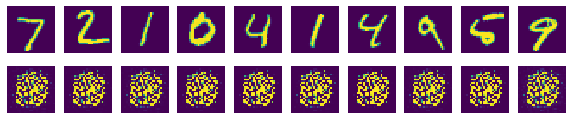

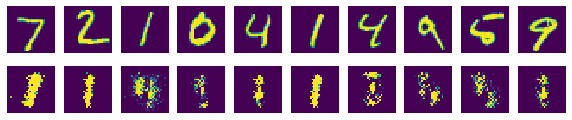

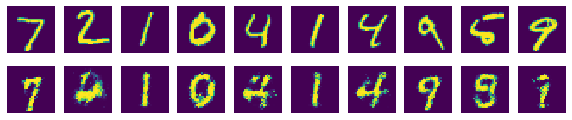

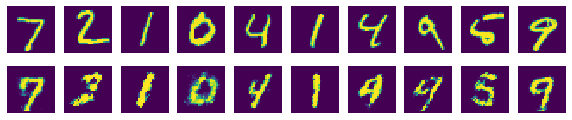

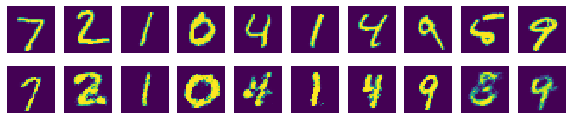

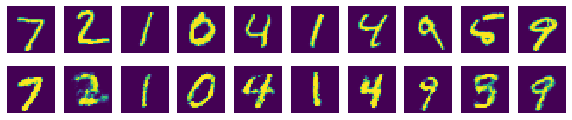

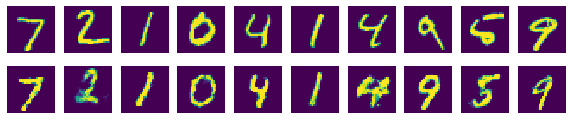

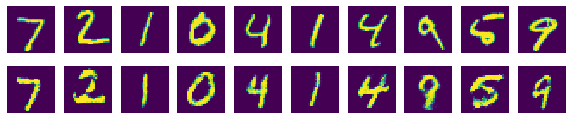

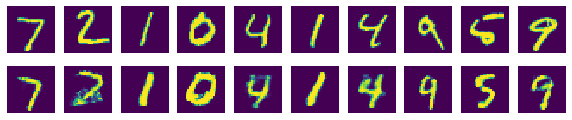

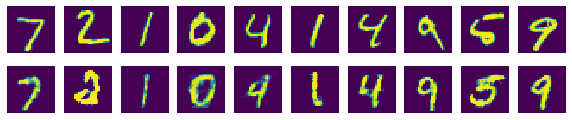

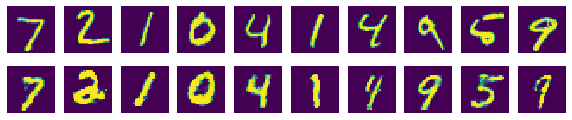

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./mnist/data/", one_hot=True)

#########
# 옵션 설정
######

total_epoch = 100
batch_size = 100
n_hidden = 256
n_input = 28 * 28
n_noise = 128
n_class = 10

#########
# 신경망 모델 구성
######

X = tf.placeholder(tf.float32, [None, n_input])
Y = tf.placeholder(tf.float32, [None, n_class])
Z = tf.placeholder(tf.float32, [None, n_noise])

def generator(noise, labels):
  with tf.variable_scope('generator'):
    inputs = tf.concat([noise, labels], 1)

    hidden = tf.layers.dense(inputs, n_hidden, activation=tf.nn.relu)
    output = tf.layers.dense(hidden, n_input, activation=tf.nn.sigmoid)

  return output


def discriminator(inputs, labels, reuse=None):
    with tf.variable_scope('discriminator') as scope:
        if reuse: 
          scope.reuse_variables()

        inputs = tf.concat([inputs, labels], 1)

        hidden = tf.layers.dense(inputs, n_hidden, activation=tf.nn.relu)
        output = tf.layers.dense(hidden, 1, activation=None)

    return output

def get_noise(batch_size, n_noise):
    return np.random.uniform(-1., 1., size=[batch_size, n_noise])

G = generator(Z, Y)
D_real = discriminator(X, Y)
D_gene = discriminator(G, Y, True)

loss_D_real = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(
                        logits=D_real, labels=tf.ones_like(D_real)))
loss_D_gene = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(
                        logits=D_gene, labels=tf.zeros_like(D_gene)))
loss_D = loss_D_real + loss_D_gene

loss_G = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(
                        logits=D_gene, labels=tf.ones_like(D_gene)))

vars_D = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
vars_G = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')

train_D = tf.train.AdamOptimizer().minimize(loss_D, var_list=vars_D)
train_G = tf.train.AdamOptimizer().minimize(loss_G, var_list=vars_G)

#########
# 신경망 모델 학습
######

sess = tf.Session()
sess.run(tf.global_variables_initializer())

total_batch = int(mnist.train.num_examples/batch_size)
loss_val_D, loss_val_G = 0, 0

for epoch in range(total_epoch):
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        noise = get_noise(batch_size, n_noise)

        _, loss_val_D = sess.run([train_D, loss_D],
                                 feed_dict={X: batch_xs, Y: batch_ys, Z: noise})
        _, loss_val_G = sess.run([train_G, loss_G],
                                 feed_dict={Y: batch_ys, Z: noise})

    print('Epoch:', '%04d' % (epoch+1),
          'D loss: {:.4}'.format(loss_val_D),
          'G loss: {:.4}'.format(loss_val_G))

    #########
    # 학습이 되어가는 모습을 보기 위해 주기적으로 레이블에 따른 이미지를 생성하여 저장
    ######
    if epoch == 0 or (epoch + 1) % 10 == 0:
        sample_size = 10
        noise = get_noise(sample_size, n_noise)
        samples = sess.run(G,
                           feed_dict={Y: mnist.test.labels[:sample_size],
                                      Z: noise})

        fig, ax = plt.subplots(2, sample_size, figsize=(sample_size, 2))

        for i in range(sample_size):
            ax[0][i].set_axis_off()
            ax[1][i].set_axis_off()

            ax[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
            ax[1][i].imshow(np.reshape(samples[i], (28, 28)))

        # plt.savefig('samples2/{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
        # plt.close(fig)